In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

### Let's declare (or import) models

In [5]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import spotpy
import xarray as xr
from spotpy.examples.spot_setup_hymod_python import spot_setup

In [4]:
spot_setup=spot_setup(spotpy.objectivefunctions.rmse)
sampler=spotpy.algorithms.sceua(spot_setup, dbname='SCEUA_hymod', dbformat='csv')

repetitions=6000

In [5]:
sampler.sample(repetitions, ngs=7, kstop=3, peps=0.1, pcento=0.1)


Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  6000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'SCEUA_hymod.csv' created.
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
ComplexEvo loop #2 in progress...
420 of 6000, minimal objective function=7.99094, time remaining: 00:00:27
ComplexEvo loop #3 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 6.581199
ComplexEvo loop #4 in progress...
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 3.679482
ComplexEvo loop #5 in progress...
915 of 6000, minimal objective function=7.6305, time remaining: 00:00:23
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 1.957181


In [6]:
results = spotpy.analyser.load_csv_results('SCEUA_hymod')

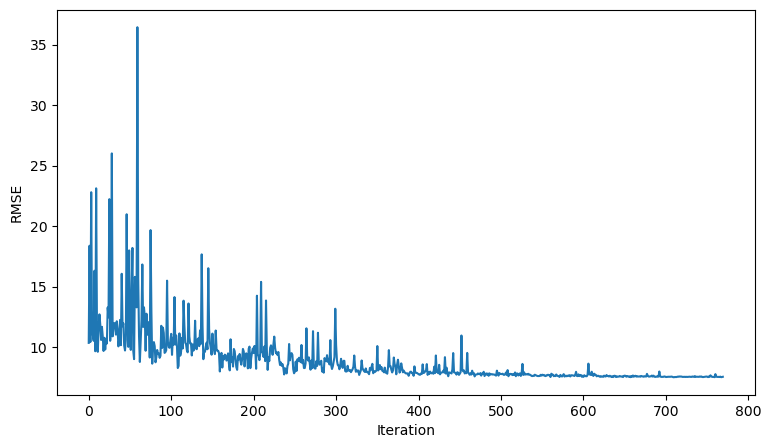

In [9]:
fig= plt.figure(1,figsize=(9,5))
plt.plot(results['like1'])
plt.ylabel('RMSE')
plt.xlabel('Iteration');

In [12]:
bestindex,bestobjf = spotpy.analyser.get_minlikeindex(results)
best_model_run = results[bestindex]

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])

Run number 709 has the lowest objectivefunction with: 7.5147


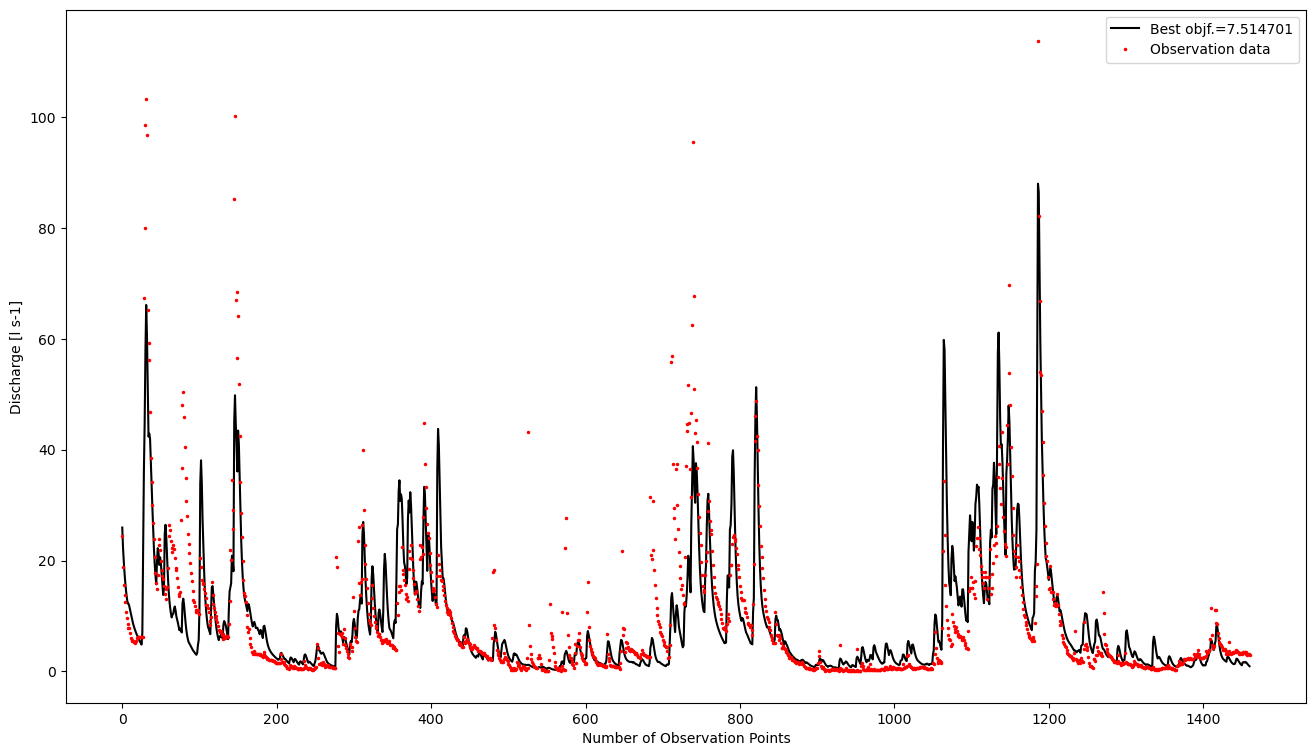

In [14]:
fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])

fig= plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1)
ax.plot(best_simulation,color='black',linestyle='solid', label='Best objf.='+str(bestobjf))
ax.plot(spot_setup.evaluation(),'r.',markersize=3, label='Observation data')
plt.xlabel('Number of Observation Points')
plt.ylabel ('Discharge [l s-1]')
plt.legend(loc='upper right');

In [8]:
from spotpy.parameter import Uniform
from spotpy.objectivefunctions import rmse
from model_scripts import hbv


class hbv_setup(object):
    """
    16 parameters
    BETA   - parameter that determines the relative contribution to runoff from rain or snowmelt
             [1, 6]
    CET    - Evaporation correction factor
             (should be 0 if we don't want to change (Oudin et al., 2005) formula values)
             [0, 0.3]
    FC     - maximum soil moisture storage
             [50, 500]
    K0     - recession coefficient for surface soil box (upper part of SUZ)
             [0.01, 0.4]
    K1     - recession coefficient for upper groudwater box (main part of SUZ)
             [0.01, 0.4]
    K2     - recession coefficient for lower groudwater box (whole SLZ)
             [0.001, 0.15]
    LP     - Threshold for reduction of evaporation (SM/FC)
             [0.3, 1]
    MAXBAS - routing parameter, order of Butterworth filter
             [1, 7]
    PERC   - percolation from soil to upper groundwater box
             [0, 3]
    UZL    - threshold parameter for grondwater boxes runoff (mm)
             [0, 500]
    PCORR  - Precipitation (input sum) correction factor
             [0.5, 2]
    TT     - Temperature which separate rain and snow fraction of precipitation
             [-1.5, 2.5]
    CFMAX  - Snow melting rate (mm/day per Celsius degree)
             [1, 10]
    SFCF   - SnowFall Correction Factor
             [0.4, 1]
    CFR    - Refreezing coefficient
             [0, 0.1] (usually 0.05)
    CWH    - Fraction (portion) of meltwater and rainfall which retain in snowpack (water holding capacity)
             [0, 0.2] (usually 0.1)

    """
    
    beta = Uniform(low=1., high=6.)
    cet = Uniform(low=0., high=0.3)
    fc = Uniform(low=50., high=500.)
    k0 = Uniform(low=0.01, high=0.4)
    k1 = Uniform(low=0.01, high=0.4)
    k2 = Uniform(low=0.001, high=0.15)
    lp = Uniform(low=0.3, high=1.)
    maxbas = Uniform(low=1., high=7.)
    perc = Uniform(low=0., high=3.)
    uzl = Uniform(low=0., high=500.)
    pcorr = Uniform(low=0.5, high=2.)
    tt = Uniform(low=-1.5, high=2.5)
    cfmax = Uniform(low=1., high=10.)
    sfcf = Uniform(low=0.4, high=1.)
    cfr = Uniform(low=0., high=1.0, optguess=0.05)
    cwh = Uniform(low=0., high=0.2, optguess=0.1)

    def __init__(self, data_file: pd.DataFrame, obj_func=None):
        self.obj_func = obj_func
        self.obs_q = data_file.loc[:, "q_mm_day"].values
        temp_max = data_file.loc[:, "t_min_e5l"].values
        temp_min = data_file.loc[:, "t_max_e5l"].values
        temp_mean = (temp_max + temp_min) / 2
        evap = data_file.loc[:, "E"].values
        prcp = data_file.loc[:, "prcp_e5l"].values

        self.model_df = pd.DataFrame()
        self.model_df["Temp"] = temp_mean
        self.model_df["Evap"] = evap
        self.model_df["Prec"] = prcp
        self.model_df["Q_mm"] = self.obs_q
        self.model_df.index = data_file.index

    def simulation(self, params):
        
        sim_results = hbv.simulation(self.model_df, params)
        
        return sim_results
    
    def evaluation(self):
        return self.obs_q
    
    def objectivefunction(self, simulation, evaluation, params=None):
        # SPOTPY expects to get one or multiple values back,
        # that define the performance of the model run
        if not self.obj_func:
            # This is used if not overwritten by user
            like = rmse(evaluation, simulation)
        else:
            # Way to ensure flexible spot setup class
            like = self.obj_func(evaluation, simulation)
        return like
    

In [67]:
from calibration import model_setups

In [86]:


gauge_id = "9415"
with xr.open_dataset(f"/Users/dmbrmv/Development/geo_data/great_db/nc_all_q/{gauge_id}.nc") as f:
    example_df = f.to_pandas()
    example_df = example_df.drop("gauge_id", axis=1)
    train_df, test_df = example_df[:"2018-12-31"], example_df["2019-01-01":]

hbv_calibrated = pathlib.Path("./hbv_calibrated")
hbv_calibrated.mkdir(exist_ok=True, parents=True)
hbv_gauge_setup = hbv_setup(data_file=train_df)

In [25]:
sampler = spotpy.algorithms.sceua(hbv_gauge_setup, dbname=f'{hbv_calibrated}/{gauge_id}', dbformat='csv')

hbv_params = 16
gr4j_params = 6

sampler.sample(repetitions=60000, ngs=hbv_params+6, kstop=3, peps=0.1, pcento=0.1)


Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  60000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'hbv_calibrated/9415.csv' created.
18 of 60000, minimal objective function=0.875424, time remaining: 01:46:28
38 of 60000, minimal objective function=0.875424, time remaining: 01:45:07
58 of 60000, minimal objective function=0.875424, time remaining: 01:43:26
78 of 60000, minimal objective function=0.875424, time remaining: 01:42:32
98 of 60000, minimal objective function=0.875424, time remaining: 01:42:36
118 of 60000, minimal objective function=0.875424, time remaining: 01:42:10
138 of 60000, minimal objective function=0.875424, time remaining: 01:42:01
158 of 60000, minimal objective function=0.731359, time remaining: 01:41:58
179 of 60000, minimal objective function=0.731359, time remaining: 01:41:39
200 of 60000, minimal objective funct

In [28]:
gauge_results = spotpy.analyser.load_csv_results(f'{hbv_calibrated}/{gauge_id}')

bestindex,bestobjf = spotpy.analyser.get_minlikeindex(gauge_results)
best_model_run = gauge_results[bestindex]

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])

Run number 154 has the lowest objectivefunction with: 0.7314


In [44]:
best_hbv = spotpy.analyser.get_best_parameterset(gauge_results)

Best parameter set:
beta=5.835542, cet=0.018101932, fc=264.42673, k0=0.35249722, k1=0.37489536, k2=0.11141935, lp=0.5687837, maxbas=6.6688576, perc=2.0072856, uzl=366.85736, pcorr=1.8194364, tt=1.9412215, cfmax=7.218706, sfcf=0.9422665, cfr=0.6794357, cwh=0.12431742


In [49]:
def hbv_ready_file(data_file: pd.DataFrame):
    
    obs_q = data_file.loc[:, "q_mm_day"].values
    temp_max = data_file.loc[:, "t_min_e5l"].values
    temp_min = data_file.loc[:, "t_max_e5l"].values
    temp_mean = (temp_max + temp_min) / 2
    evap = data_file.loc[:, "E"].values
    prcp = data_file.loc[:, "prcp_e5l"].values

    model_df = pd.DataFrame()
    model_df.index = data_file.index
    model_df["Temp"] = temp_mean
    model_df["Evap"] = evap
    model_df["Prec"] = prcp
    model_df["Q_mm"] = obs_q
    
    return model_df

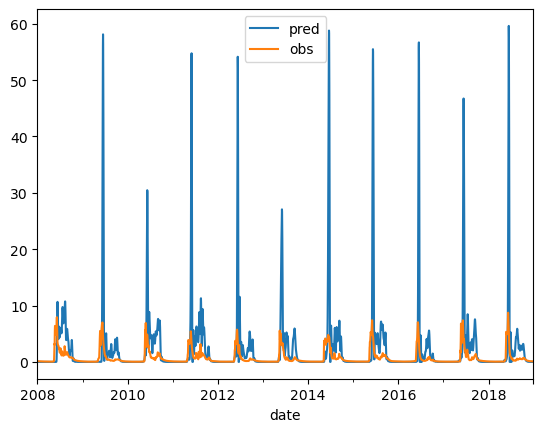

In [65]:
res_df = pd.DataFrame()

res_df["obs"] = train_df["q_mm_day"]
res_df["pred"] = hbv.simulation(hbv_ready_file(train_df), params=best_hbv[0])

res_df[["pred", "obs"]].plot();

In [ ]:
pd.read_csv("DELETE_ME_9415_test.csv",
                      parse_dates=True,
                      index_col="date")

### Run some stuff

In [1]:
import spotpy
import pathlib
import xarray as xr
import pandas as pd
from model_scripts import hbv
from scripts.data_readers import hbv_ready_file

gauge_id = "9415"
with xr.open_dataset(f"/Users/dmbrmv/Development/geo_data/great_db/nc_all_q/{gauge_id}.nc") as f:
    example_df = f.to_pandas()
    example_df = example_df.drop("gauge_id", axis=1)
    train_df, test_df = example_df[:"2018-12-31"], example_df["2019-01-01":]

hbv_calibrated = pathlib.Path("./hbv_calibrated")
hbv_calibrated.mkdir(exist_ok=True, parents=True)

gauge_results = spotpy.analyser.load_csv_results(f"{hbv_calibrated}/{gauge_id}")

best_hbv_parameters = spotpy.analyser.get_best_parameterset(gauge_results)



res_df = pd.DataFrame()

res_df["obs"] = test_df["q_mm_day"]
res_df["pred"] = hbv.simulation(hbv_ready_file(test_df), params=best_hbv_parameters[0])

# res_df[["pred", "obs"]].to_csv(f"DELETE_ME_{gauge_id}_test.csv")

Best parameter set:
beta=2.382049, cet=0.3, fc=50.5, k0=0.068243206, k1=0.058824535, k2=0.10796338, lp=0.45921144, maxbas=3.7045753, perc=2.1479235, uzl=332.31604, pcorr=0.8369045, tt=-0.5525843, cfmax=2.4888618, sfcf=0.9135924, cfr=0.73886687, cwh=0.040442728


In [ ]:
spotpy.analyser.

In [19]:
import numpy as np

arr = np.array(best_hbv_parameters)

with open("./gr4j_calibrated/kill_me.npy", "wb") as f:
    np.save(f, arr)

In [24]:
with pathlib.Path("./gr4j_calibrated/kill_me.npy") as f:
    f.unlink()

In [15]:
with open("./gr4j_calibrated/kill_me.npy", "rb") as f:

    a = np.load(f)

### KGE + MLE ERA5-Land precipitation

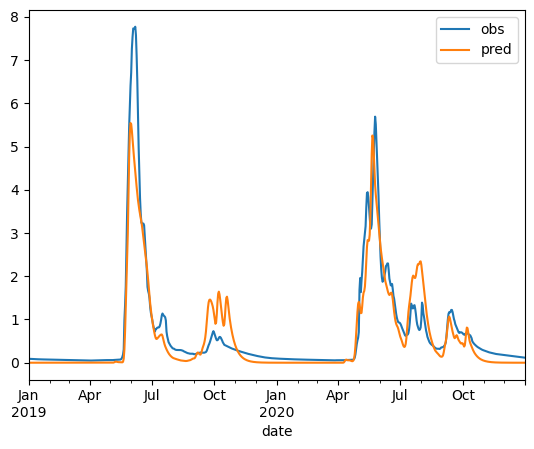

In [31]:
res_df.plot();

### Multiprocessing stuff

In [32]:
import pathlib
from pathlib import Path

import geopandas as gpd
import spotpy
import xarray as xr

from calibration.model_setups import hbv_setup
from spotpy.objectivefunctions import kge

gauges = [i.stem for i in pathlib.Path(f"/Users/dmbrmv/Development/geo_data/great_db/nc_all_q").glob("*.nc")]

# gauge_id = "9415"

In [38]:
def hbv_single_core(g_id: str) -> None:
    """
    
    Parameters
    ----------
    gauge_id (str) : name of the gauge to use 

    Returns
    -------
    None
    """
    with xr.open_dataset(
            f"/Users/dmbrmv/Development/geo_data/great_db/nc_all_q/{g_id}.nc"
    ) as f:
        example_df = f.to_pandas()
        example_df = example_df.drop("gauge_id", axis=1)
        train_df, test_df = example_df[:"2018-12-31"], example_df["2019-01-01":]

    hbv_calibrated: Path = pathlib.Path("./hbv_calibrated")
    hbv_calibrated.mkdir(exist_ok=True, parents=True)

    sampler = spotpy.algorithms.mle(
        hbv_setup(data_file=train_df, obj_func=kge),
        dbname=f"{hbv_calibrated}/{g_id}",
        dbformat="csv",
        random_state=42,
    )

    sampler.sample(repetitions=4200)
    
    return None
    

In [36]:
import multiprocessing as mp

# Specify the number of processes to be used
num_processes = 4  # You can adjust this value as needed

# Create a multiprocessing pool with the specified number of processes
pool = mp.Pool(processes=num_processes)

# Map the calculation function to the list of numbers and run it in parallel
results = pool.map(hbv_single_core, gauges)

# Close the pool to free resources
pool.close()
pool.join()